In [1]:
"""
Enhancements to Stock Price Prediction Project

This script demonstrates several enhancements that can be integrated into the stock price prediction project:
1. Additional Technical Indicators (Bollinger Bands and MACD).
2. A simple Backtesting Strategy to simulate trading based on predictions.
3. Hyperparameter Tuning for the LSTM model using Keras Tuner.
4. (Optional) A stub for integrating sentiment analysis.

Before running, ensure you have installed the required libraries:
pip install yfinance pandas numpy matplotlib scikit-learn tensorflow keras-tuner
"""

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras_tuner as kt

In [2]:
# 1. Additional Technical Indicators
def add_technical_indicators(data):
    """
    Adds Bollinger Bands and MACD indicators to the DataFrame.
    """
    # Bollinger Bands: 20-day moving average and standard deviation
    data['MA20'] = data['Close'].rolling(window=20).mean()
    data['Std20'] = data['Close'].rolling(window=20).std()
    data['Upper_BB'] = data['MA20'] + (data['Std20'] * 2)
    data['Lower_BB'] = data['MA20'] - (data['Std20'] * 2)
    
    # MACD: 12-day EMA, 26-day EMA, and MACD line
    data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA12'] - data['EMA26']
    # MACD Signal: 9-day EMA of MACD
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    
    return data

In [3]:
# 2. Backtesting Strategy: A Simple Simulation
def simple_backtest(predictions, actual, initial_capital=10000):
    """
    Simulates a basic trading strategy:
      - Buy when the predicted price exceeds the current actual price.
      - Sell when the predicted price falls below the current actual price.
    Returns a DataFrame with simulated portfolio values.
    """
    capital = initial_capital
    position = 0  # 0: no stock held, 1: stock held
    portfolio_values = []

    for i in range(len(predictions)):
        # Buy signal: predicted price > actual price, and no position held.
        if predictions[i] > actual[i] and position == 0:
            position = capital / actual[i]  # Buy as many shares as possible.
            capital = 0
        # Sell signal: predicted price < actual price, and holding stock.
        elif predictions[i] < actual[i] and position > 0:
            capital = position * actual[i]  # Sell all shares.
            position = 0
        
        # Calculate current portfolio value.
        current_value = capital if position == 0 else position * actual[i]
        portfolio_values.append(current_value)
    
    return pd.DataFrame({'Portfolio Value': portfolio_values})

In [4]:
# 3. Hyperparameter Tuning for the LSTM Model
def build_model(hp, input_shape):
    """
    Builds an LSTM model where hyperparameters are tunable.
    """
    model = Sequential()
    # Tune the number of units in the first LSTM layer.
    units = hp.Int('units', min_value=32, max_value=128, step=32)
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Optionally add a second LSTM layer.
    if hp.Boolean('second_layer'):
        units_2 = hp.Int('units_2', min_value=32, max_value=128, step=32)
        model.add(LSTM(units_2))
        model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    else:
        model.add(LSTM(units))
        model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [5]:
def hyperparameter_tuning(X_train, y_train, input_shape):
    """
    Uses Keras Tuner to find the best hyperparameters for the LSTM model.
    """
    tuner = kt.RandomSearch(
        lambda hp: build_model(hp, input_shape),
        objective='val_loss',
        max_trials=5,
        directory='hyperparam_tuning',
        project_name='stock_price_lstm'
    )
    tuner.search(X_train, y_train, epochs=10, validation_split=0.1)
    best_model = tuner.get_best_models(num_models=1)[0]
    return best_model

In [6]:
# 4. (Optional) Sentiment Analysis Integration Stub
def analyze_sentiment(news_headlines):
    """
    Stub for integrating sentiment analysis on news headlines.
    You could integrate libraries such as TextBlob or Vader to compute sentiment.
    Returns a placeholder sentiment score.
    """
    # Example (commented out):
    # from textblob import TextBlob
    # sentiments = [TextBlob(headline).sentiment.polarity for headline in news_headlines]
    # return np.mean(sentiments)
    return 0  # Placeholder score

Trial 5 Complete [00h 00m 24s]
val_loss: 0.0006184690282680094

Best val_loss So Far: 0.000278348452411592
Total elapsed time: 00h 02m 25s
Epoch 1/20
72/72 [==============================] - 6s 54ms/step - loss: 1.1019e-04 - val_loss: 4.4583e-04
Epoch 2/20
72/72 [==============================] - 3s 42ms/step - loss: 9.0895e-05 - val_loss: 3.8503e-04
Epoch 3/20
72/72 [==============================] - 3s 41ms/step - loss: 9.4928e-05 - val_loss: 2.9802e-04
Epoch 4/20
72/72 [==============================] - 3s 42ms/step - loss: 9.6209e-05 - val_loss: 5.5323e-04
Epoch 5/20
72/72 [==============================] - 3s 46ms/step - loss: 9.4870e-05 - val_loss: 5.7090e-04
Epoch 6/20
72/72 [==============================] - 3s 46ms/step - loss: 8.8406e-05 - val_loss: 4.1494e-04
Epoch 7/20
72/72 [==============================] - 3s 45ms/step - loss: 8.0192e-05 - val_loss: 4.9785e-04
Epoch 8/20
72/72 [==============================] - 3s 45ms/step - loss: 9.1371e-05 - val_loss: 7.9507e-04
Epoch

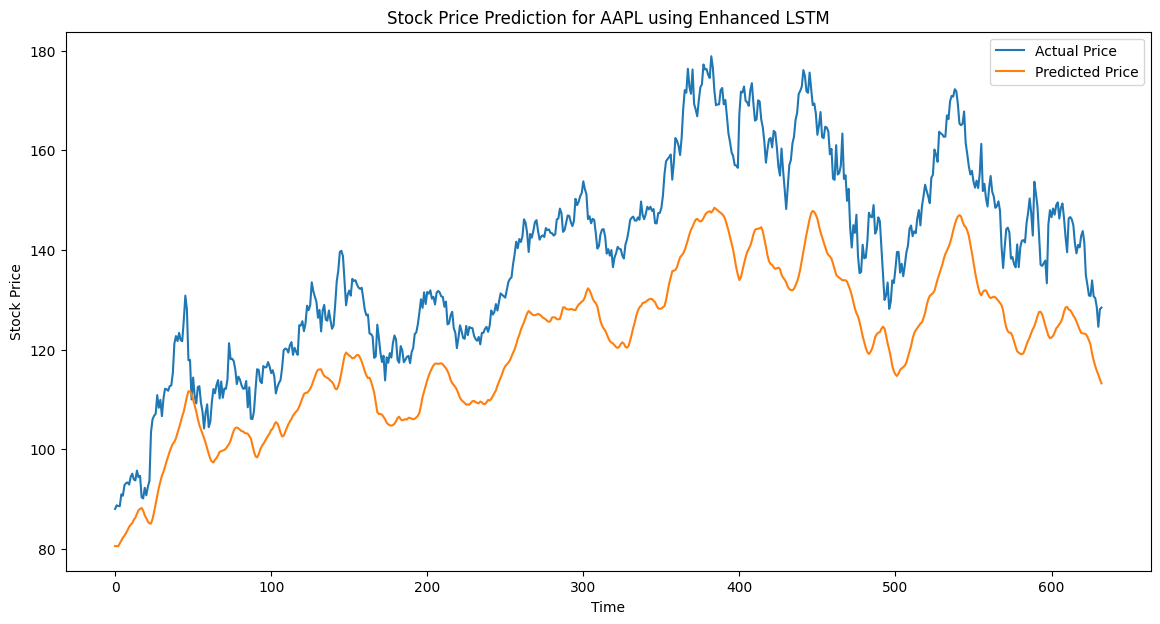

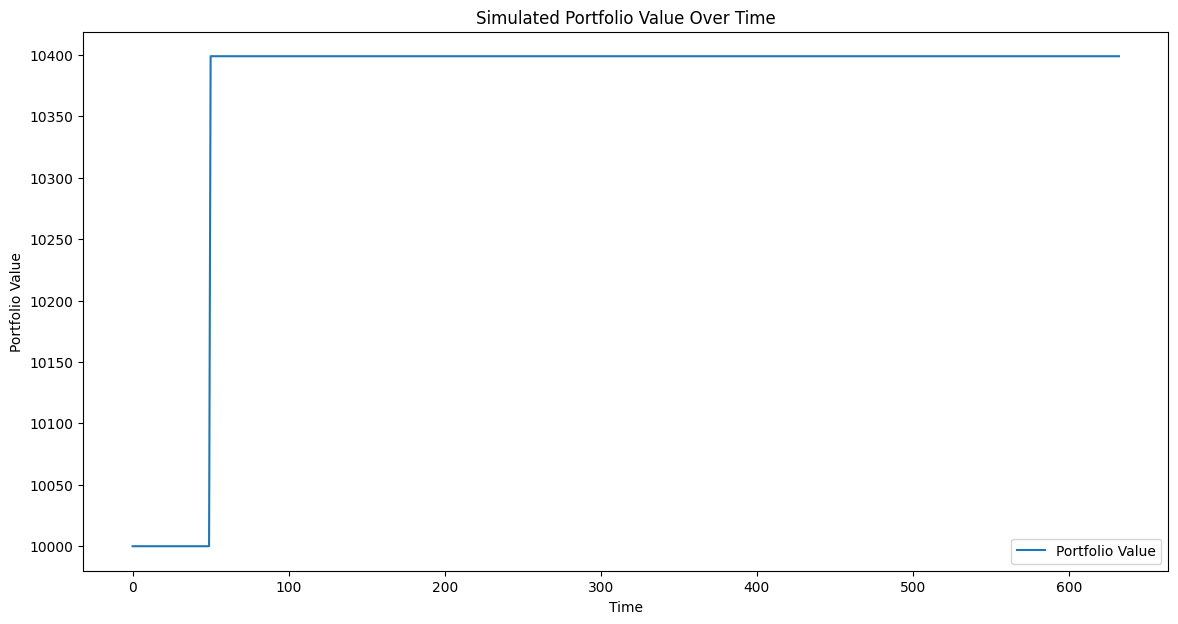

In [7]:
# Main function demonstrating the enhanced workflow.
def main():
    # Download historical stock data.
    ticker = 'AAPL'
    data = yf.download(ticker, start='2010-01-01', end='2023-01-01')
    
    # Add additional technical indicators.
    data = add_technical_indicators(data)
    
    # Existing feature engineering.
    data['Prev_Close'] = data['Close'].shift(1)
    data['MA10'] = data['Close'].rolling(window=10).mean()
    data['MA50'] = data['Close'].rolling(window=50).mean()
    
    # Compute a simple RSI.
    delta = data['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    avg_gain = up.rolling(window=14, min_periods=14).mean()
    avg_loss = down.rolling(window=14, min_periods=14).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    data = data.dropna()
    
    # Define features and target. We include the new indicators.
    features = ['Prev_Close', 'MA10', 'MA50', 'RSI', 
                'Upper_BB', 'Lower_BB', 'MACD', 'MACD_Signal']
    target = 'Close'
    dataset = data[features + [target]].copy()
    
    # Normalize the dataset.
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(dataset)
    
    # Create sequences for the LSTM model.
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(seq_length, len(data)):
            X.append(data[i-seq_length:i, :-1])
            y.append(data[i, -1])
        return np.array(X), np.array(y)
    
    seq_length = 60
    X, y = create_sequences(scaled_data, seq_length)
    
    # Time-based train-test split (80/20).
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Hyperparameter tuning to get the best model.
    input_shape = (X_train.shape[1], X_train.shape[2])
    best_model = hyperparameter_tuning(X_train, y_train, input_shape)
    
    # Further train the tuned model.
    history = best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)
    
    # Make predictions.
    predictions = best_model.predict(X_test)
    
    # Function to reverse scaling.
    def inverse_scale(scaled_values, scaler, feature_index, total_features):
        placeholder = np.zeros((len(scaled_values), total_features))
        placeholder[:, feature_index] = scaled_values.flatten()
        inv = scaler.inverse_transform(placeholder)[:, feature_index]
        return inv

    target_index = len(features)  # index for 'Close'
    predictions_inv = inverse_scale(predictions, scaler, target_index, dataset.shape[1])
    y_test_inv = inverse_scale(y_test.reshape(-1, 1), scaler, target_index, dataset.shape[1])
    
    rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
    print("Test RMSE after Hyperparameter Tuning:", rmse)
    
    # Visualize actual vs. predicted stock prices.
    plt.figure(figsize=(14, 7))
    plt.plot(y_test_inv, label='Actual Price')
    plt.plot(predictions_inv, label='Predicted Price')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.title(f'Stock Price Prediction for {ticker} using Enhanced LSTM')
    plt.legend()
    plt.show()
    
    # Run backtesting simulation.
    portfolio_df = simple_backtest(predictions_inv, y_test_inv)
    portfolio_df.plot(figsize=(14,7), title="Simulated Portfolio Value Over Time")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.show()
    
if __name__ == '__main__':
    main()